## Installing libraries that are not in collab

In [1]:
# Install Transformers
!pip install transformers
# To get model summary
!pip install torchinfo

In [2]:
from google.colab import drive
drive.mount("/content/drive/")
!ls

Mounted at /content/drive/
drive  sample_data


## Import Libraries
Importing the libraries that are required to perform operations on the dataset.

In [3]:
import json
import numpy as np
import pandas as pd
import re
import torch
import random
import torch.nn as nn
import transformers
import seaborn as sn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torchinfo import summary
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.utils.class_weight import compute_class_weight
from transformers import DistilBertTokenizer, DistilBertModel, RobertaTokenizer, RobertaModel, AutoModel, BertTokenizerFast
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

device = "cuda" if torch.cuda.is_available() else "cpu"

## Data preprocessing
Doing required processing of data.

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Datasets/lucy/data.csv")

In [5]:
df.head()

,Unnamed: 0,text,intent
0,0,Hi,greeting
1,1,How are you,greeting
2,2,Warm welcome,greeting
3,3,Thank you,greeting
4,4,How do you do,greeting


In [6]:
len_labels = len(df.intent.unique())
print(len_labels)

42


In [7]:
df["intent"].value_counts()

goodbye                  102
swear                    101
syllabus                 101
greeting                 100
scholarship              100
uniform                  100
random                   100
task                     100
ragging                  100
hod                      100
transport                100
faculty                  100
studentportal            100
facultyportal            100
sports                   100
fest                     100
other                    100
universityaffiliation    100
medical                  100
collegetype              100
collegeintake            100
notice                   100
admission                100
hours                    100
csehod                   100
placement                100
creator                  100
name                     100
canteen                  100
library                  100
document                 100
event                    100
principal                100
hostel                   100
location      

In [8]:
# Create a list to store training and testing sets
train_data, test_data = [], []
# Group the DataFrame by the 'intent' column
grouped = df.groupby('intent')

# Shuffle and split each group into training and testing sets (80-20 split)
for _, group_df in grouped:
    # Shuffle the rows within each group
    group_df = group_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Split the shuffled group into training and testing sets
    train_set, test_set = train_test_split(group_df, test_size=0.2, random_state=42)

    train_data.append(train_set)
    test_data.append(test_set)

# Concatenate the training and testing sets
train_df = pd.concat(train_data, ignore_index=True)
test_df = pd.concat(test_data, ignore_index=True)

# Display the shapes of the training and testing sets
print("Training set shape:", train_df.shape)
print("Testing set shape:", test_df.shape)

Training set shape: (3356, 3)
Testing set shape: (843, 3)


In [9]:
train_df["intent"].value_counts()

goodbye                  81
admission                80
canteen                  80
name                     80
notice                   80
number                   80
other                    80
placement                80
principal                80
ragging                  80
random                   80
scholarship              80
sports                   80
studentportal            80
swear                    80
syllabus                 80
task                     80
transport                80
uniform                  80
medical                  80
location                 80
library                  80
facultyportal            80
collegeintake            80
collegetype              80
course                   80
creator                  80
csehod                   80
document                 80
event                    80
faculty                  80
fees                     80
fest                     80
greeting                 80
hod                      80
hostel              

In [10]:
print("Total: ", len(train_df.intent.unique()))

Total:  42


In [11]:
test_df["intent"].value_counts()

syllabus                 21
swear                    21
goodbye                  21
admission                20
ragging                  20
name                     20
notice                   20
number                   20
other                    20
placement                20
principal                20
salutation               20
random                   20
medical                  20
scholarship              20
sports                   20
studentportal            20
task                     20
transport                20
uniform                  20
menu                     20
location                 20
canteen                  20
library                  20
collegeintake            20
collegetype              20
course                   20
creator                  20
csehod                   20
document                 20
event                    20
facilities               20
faculty                  20
facultyportal            20
fees                     20
fest                

In [12]:
print("Total: ", len(train_df.intent.unique()))

Total:  42


In [13]:
# Converting the labels into encodings
le = LabelEncoder()
train_df['intent'] = le.fit_transform(train_df['intent'])
test_df['intent'] = le.fit_transform(test_df['intent'])

In [14]:
# check class distribution
train_df['intent'].value_counts(normalize = True)

14    0.024136
0     0.023838
1     0.023838
24    0.023838
25    0.023838
26    0.023838
27    0.023838
28    0.023838
29    0.023838
30    0.023838
31    0.023838
33    0.023838
34    0.023838
35    0.023838
36    0.023838
37    0.023838
38    0.023838
39    0.023838
40    0.023838
22    0.023838
21    0.023838
20    0.023838
11    0.023838
2     0.023838
3     0.023838
4     0.023838
5     0.023838
6     0.023838
7     0.023838
8     0.023838
10    0.023838
12    0.023838
13    0.023838
15    0.023838
16    0.023838
17    0.023838
18    0.023838
41    0.023838
19    0.023540
9     0.023540
23    0.023540
32    0.023242
Name: intent, dtype: float64

In [15]:
# In this example we have used all the utterances for training purpose
train_text, train_labels = train_df["text"], train_df["intent"]
test_text, test_labels = test_df["text"], test_df["intent"]

### Load Tokenizer

In [16]:
def load_tokenizer(model="bert"):
  tokenizer = None
  if model == "bert":
    # Load the BERT tokenizer
    tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")
  if model == "roberta":
    # Load the Roberta tokenizer
    tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
  if model == "distilbert":
    # Load the DistilBert tokenizer
    tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

  return tokenizer

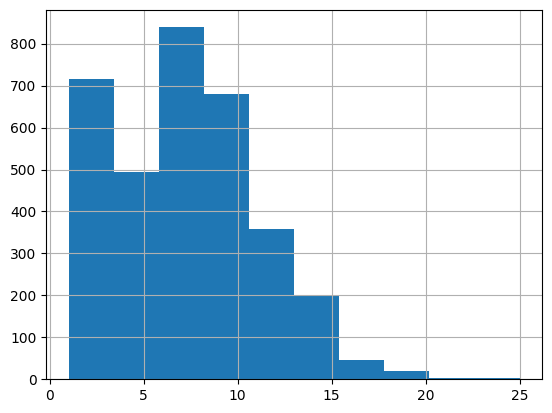

In [17]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 10)

# Based on the histogram we are selecting the max len as 9
max_seq_len = 20

In [18]:
def get_tokenized_data(model="bert"):
  tokenizer = load_tokenizer(model=model)
  # tokenize and encode sequences in the training set
  tokens_train = tokenizer(
      train_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
                    )
  # tokenize and encode sequences in the testing set
  tokens_test = tokenizer(
      test_text.tolist(),
      max_length = max_seq_len,
      padding="max_length",
      truncation=True,
      return_token_type_ids=False
  )
  return tokens_train, tokens_test

In [19]:
tokens_train, tokens_test = get_tokenized_data("bert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [20]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

In [21]:
# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

## Setting Up models parameters

In [22]:
# Define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
test_data = TensorDataset(test_seq, test_mask, test_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# DataLoader for train set and test set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

## Building our Lucy Model
To build lucy we are going to use pretrained Model and our own model.

### 1) Lucy layer

In [23]:
class Lucy(nn.Module):
  def __init__(self, pretrained_model):
       super(Lucy, self).__init__()
       self.pretrained_model = pretrained_model

       # dropout layer
       self.dropout = nn.Dropout(0.2)

       # relu activation function
       self.relu =  nn.ReLU()

       # dense layer
       self.fc1 = nn.Linear(768,512)
       self.fc2 = nn.Linear(512,256)
       self.fc3 = nn.Linear(256,len_labels)

       #softmax activation function
       self.softmax = nn.LogSoftmax(dim=1)

  #define the forward pass
  def forward(self, sent_id, mask):
      #pass the inputs to the model
      cls_hs = self.pretrained_model(sent_id, attention_mask=mask)[0][:,0]

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)

      x = self.fc2(x)
      x = self.relu(x)
      x = self.dropout(x)

      # output layer
      x = self.fc3(x)

      # apply softmax activation
      x = self.softmax(x)
      return x

### 2) Pretrained layer + Lucy layer

In [24]:
def lucy_model(device,model="bert"):
  pretrained_model = None
  if model == "bert":
    # Import BERT-base pretrained model
    pretrained_model = AutoModel.from_pretrained("bert-base-uncased")

  if model == "roberta":
    # Import Roberta pretrained model
    pretrained_model = RobertaModel.from_pretrained("roberta-base")

  if model == "distilbert":
    # Import the DistilBert pretrained model
    pretrained_model = DistilBertModel.from_pretrained("distilbert-base-uncased")

  # freeze all the parameters. This will prevent updating of model weights during fine-tuning.
  for param in pretrained_model.parameters():
        param.requires_grad = False

  lucy = Lucy(pretrained_model)

  # push the model to GPU or CPU
  lucy = lucy.to(device)

  return lucy

#### i) BERT

In [25]:
bert_model = lucy_model(device)
summary(bert_model)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─BertModel: 1-1                                        --
│    └─BertEmbeddings: 2-1                              --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─Embedding: 3-3                              (1,536)
│    │    └─LayerNorm: 3-4                              (1,536)
│    │    └─Dropout: 3-5                                --
│    └─BertEncoder: 2-2                                 --
│    │    └─ModuleList: 3-6                             (85,054,464)
│    └─BertPooler: 2-3                                  --
│    │    └─Linear: 3-7                                 (590,592)
│    │    └─Tanh: 3-8                                   --
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linea

#### ii) Roberta

In [26]:
roberta_model = lucy_model(device, model="roberta")
summary(roberta_model)

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer (type:depth-idx)                                       Param #
Lucy                                                         --
├─RobertaModel: 1-1                                          --
│    └─RobertaEmbeddings: 2-1                                --
│    │    └─Embedding: 3-1                                   (38,603,520)
│    │    └─Embedding: 3-2                                   (394,752)
│    │    └─Embedding: 3-3                                   (768)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─RobertaEncoder: 2-2                                   --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─RobertaPooler: 2-3                                    --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                           

#### iii) DistilBert

In [27]:
distilbert_model = lucy_model(device, model="distilbert")
summary(distilbert_model)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Layer (type:depth-idx)                                  Param #
Lucy                                                    --
├─DistilBertModel: 1-1                                  --
│    └─Embeddings: 2-1                                  --
│    │    └─Embedding: 3-1                              (23,440,896)
│    │    └─Embedding: 3-2                              (393,216)
│    │    └─LayerNorm: 3-3                              (1,536)
│    │    └─Dropout: 3-4                                --
│    └─Transformer: 2-2                                 --
│    │    └─ModuleList: 3-5                             (42,527,232)
├─Dropout: 1-2                                          --
├─ReLU: 1-3                                             --
├─Linear: 1-4                                           393,728
├─Linear: 1-5                                           131,328
├─Linear: 1-6                                           10,794
├─LogSoftmax: 1-7                                       --
Total

In [28]:
# define the optimizer for BERT, Roberta, DistilBERT
bert_optimizer = torch.optim.AdamW(bert_model.parameters(), lr = 1e-3)
roberta_optimizer = torch.optim.AdamW(roberta_model.parameters(), lr = 1e-3)
distilbert_optimizer = torch.optim.AdamW(distilbert_model.parameters(), lr = 1e-3)

In [29]:
#compute the class weights
class_wts = compute_class_weight(class_weight="balanced", classes=np.unique(train_labels), y=train_labels)
print(class_wts)

[0.99880952 0.99880952 0.99880952 0.99880952 0.99880952 0.99880952
 0.99880952 0.99880952 0.99880952 1.01145268 0.99880952 0.99880952
 0.99880952 0.99880952 0.98647854 0.99880952 0.99880952 0.99880952
 0.99880952 1.01145268 0.99880952 0.99880952 0.99880952 1.01145268
 0.99880952 0.99880952 0.99880952 0.99880952 0.99880952 0.99880952
 0.99880952 0.99880952 1.02442002 0.99880952 0.99880952 0.99880952
 0.99880952 0.99880952 0.99880952 0.99880952 0.99880952 0.99880952]


In [30]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

In [31]:
# loss function
cross_entropy = nn.NLLLoss(weight=weights)

In [38]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

# number of training epochs
epochs = 300

In [39]:
# function to train the model
def train(dataloader, model, optimizer):

  model.train()
  total_loss = 0
  total_correct = 0

  # empty list to save model predictions
  total_preds=[]

   # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 15 batches.
    if step % 50 == 0 and not step == 0:
      print('Batch {:>5,}  of  {:>5,}.'.format(step,    len(dataloader)))

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # get model accuracy
    p = preds.detach().cpu().numpy()
    p = torch.from_numpy(np.argmax(p, axis = 1))

    total_correct += (p == labels.detach().cpu()).float().sum()


    # compute the loss between actual and predicted values
    loss = cross_entropy(preds, labels)

    # add on to the total loss
    total_loss = total_loss + loss.item()

    # backward pass to calculate the gradients
    loss.backward()

    # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    # update parameters
    optimizer.step()

    # clear calculated gradients
    optimizer.zero_grad()

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)


  # compute the training loss of the epoch
  avg_loss = total_loss / len(dataloader)

  # compute the training accuracy of the epoch
  avg_accuracy = total_correct / len(train_data)


  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions
  return avg_loss, avg_accuracy, total_preds



# A. Train BERT

In [40]:
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, bert_model, bert_optimizer)

    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.290

Training Accuracy: 90.435 %

 Epoch 2 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.279

Training Accuracy: 91.120 %

 Epoch 3 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.263

Training Accuracy: 91.776 %

 Epoch 4 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.273

Training Accuracy: 91.120 %

 Epoch 5 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.292

Training Accuracy: 90.644 %

 Epoch 6 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.266

Training Accuracy: 91.031 %

 Epoch 7 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.258

Training Accuracy: 91.210 %

 Epoch 8 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.256

Training Accuracy: 91.478 %

 Epoch 9 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 

## Analysis of Training

In [41]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

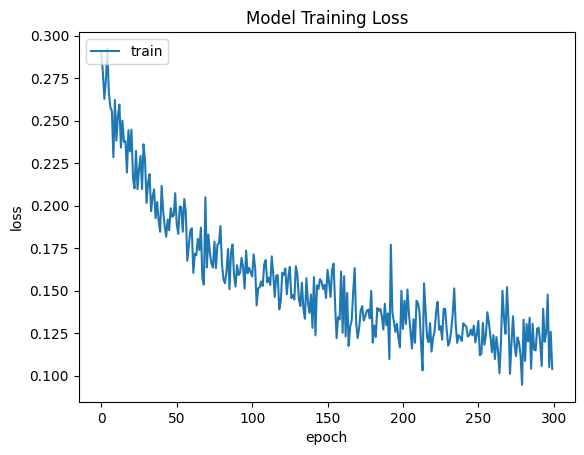

In [42]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/bert_model_loss.png")
plt.show()

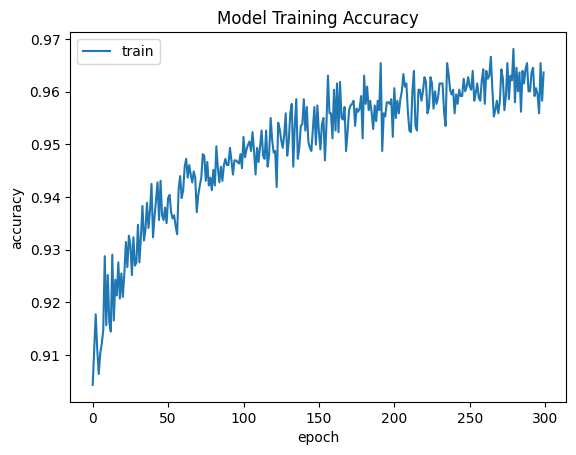

In [43]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/bert_model_accuracy.png")
plt.show()

## Saving the Lucy model

In [44]:
model_save_name = "lucy_bert.pth"
PATH = F"/content/drive/MyDrive/Colab Notebooks/lucy/{model_save_name}"

In [45]:
torch.save(bert_model.state_dict(), PATH)

## Testing the BERT

In [46]:
bert_model = lucy_model(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [47]:
bert_model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

<All keys matched successfully>

In [72]:
@torch.no_grad()
def predict(dataloader, model):

  # empty list to save model predictions
  total_preds=[]

  # iterate over batches
  for step,batch in enumerate(dataloader):
    # progress update after every 50 batches.
    if step % 50 == 0 and not step == 0:
      print("Batch {:>5,}  of  {:>5,}.'.format(step, len(dataloader))")

    # push the batch to gpu or cpu
    batch = [r.to(device) for r in batch]
    sent_id, mask, labels = batch

    # get model predictions for the current batch
    preds = model(sent_id, mask)

    # model predictions are stored on GPU. So, push it to CPU
    preds=preds.detach().cpu().numpy()

    # append the model predictions
    total_preds.append(preds)

  # predictions are in the form of (no. of batches, size of batch, no. of classes).
  # reshape the predictions in form of (number of samples, no. of classes)
  total_preds  = np.concatenate(total_preds, axis=0)#returns the loss and predictions

  return total_preds



In [73]:
test_y_preds = predict(test_dataloader, bert_model)

In [74]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [75]:
classes = le.classes_.tolist()

In [76]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)


In [77]:
test_y_true = le.inverse_transform(test_y_true)

In [78]:
test_y_preds = le.inverse_transform(test_y_preds)

In [79]:
print(test_y_true.shape)
print(test_y_preds.shape)

(843,)
(843,)


In [80]:
# Classification report
c = classification_report(test_y_true, test_y_preds)
print(c)

                       precision    recall  f1-score   support

            admission       0.90      0.90      0.90        20
              canteen       0.93      0.70      0.80        20
        collegeintake       0.95      1.00      0.98        20
          collegetype       1.00      1.00      1.00        20
               course       0.95      1.00      0.98        20
              creator       1.00      0.90      0.95        20
               csehod       0.95      0.95      0.95        20
             document       0.86      0.90      0.88        20
                event       0.83      0.75      0.79        20
           facilities       0.95      0.95      0.95        20
              faculty       1.00      0.95      0.97        20
        facultyportal       0.90      0.95      0.93        20
                 fees       0.91      1.00      0.95        20
                 fest       0.95      1.00      0.98        20
              goodbye       0.76      0.62      0.68  

90% Testing accuracy is pretty good.

In [81]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

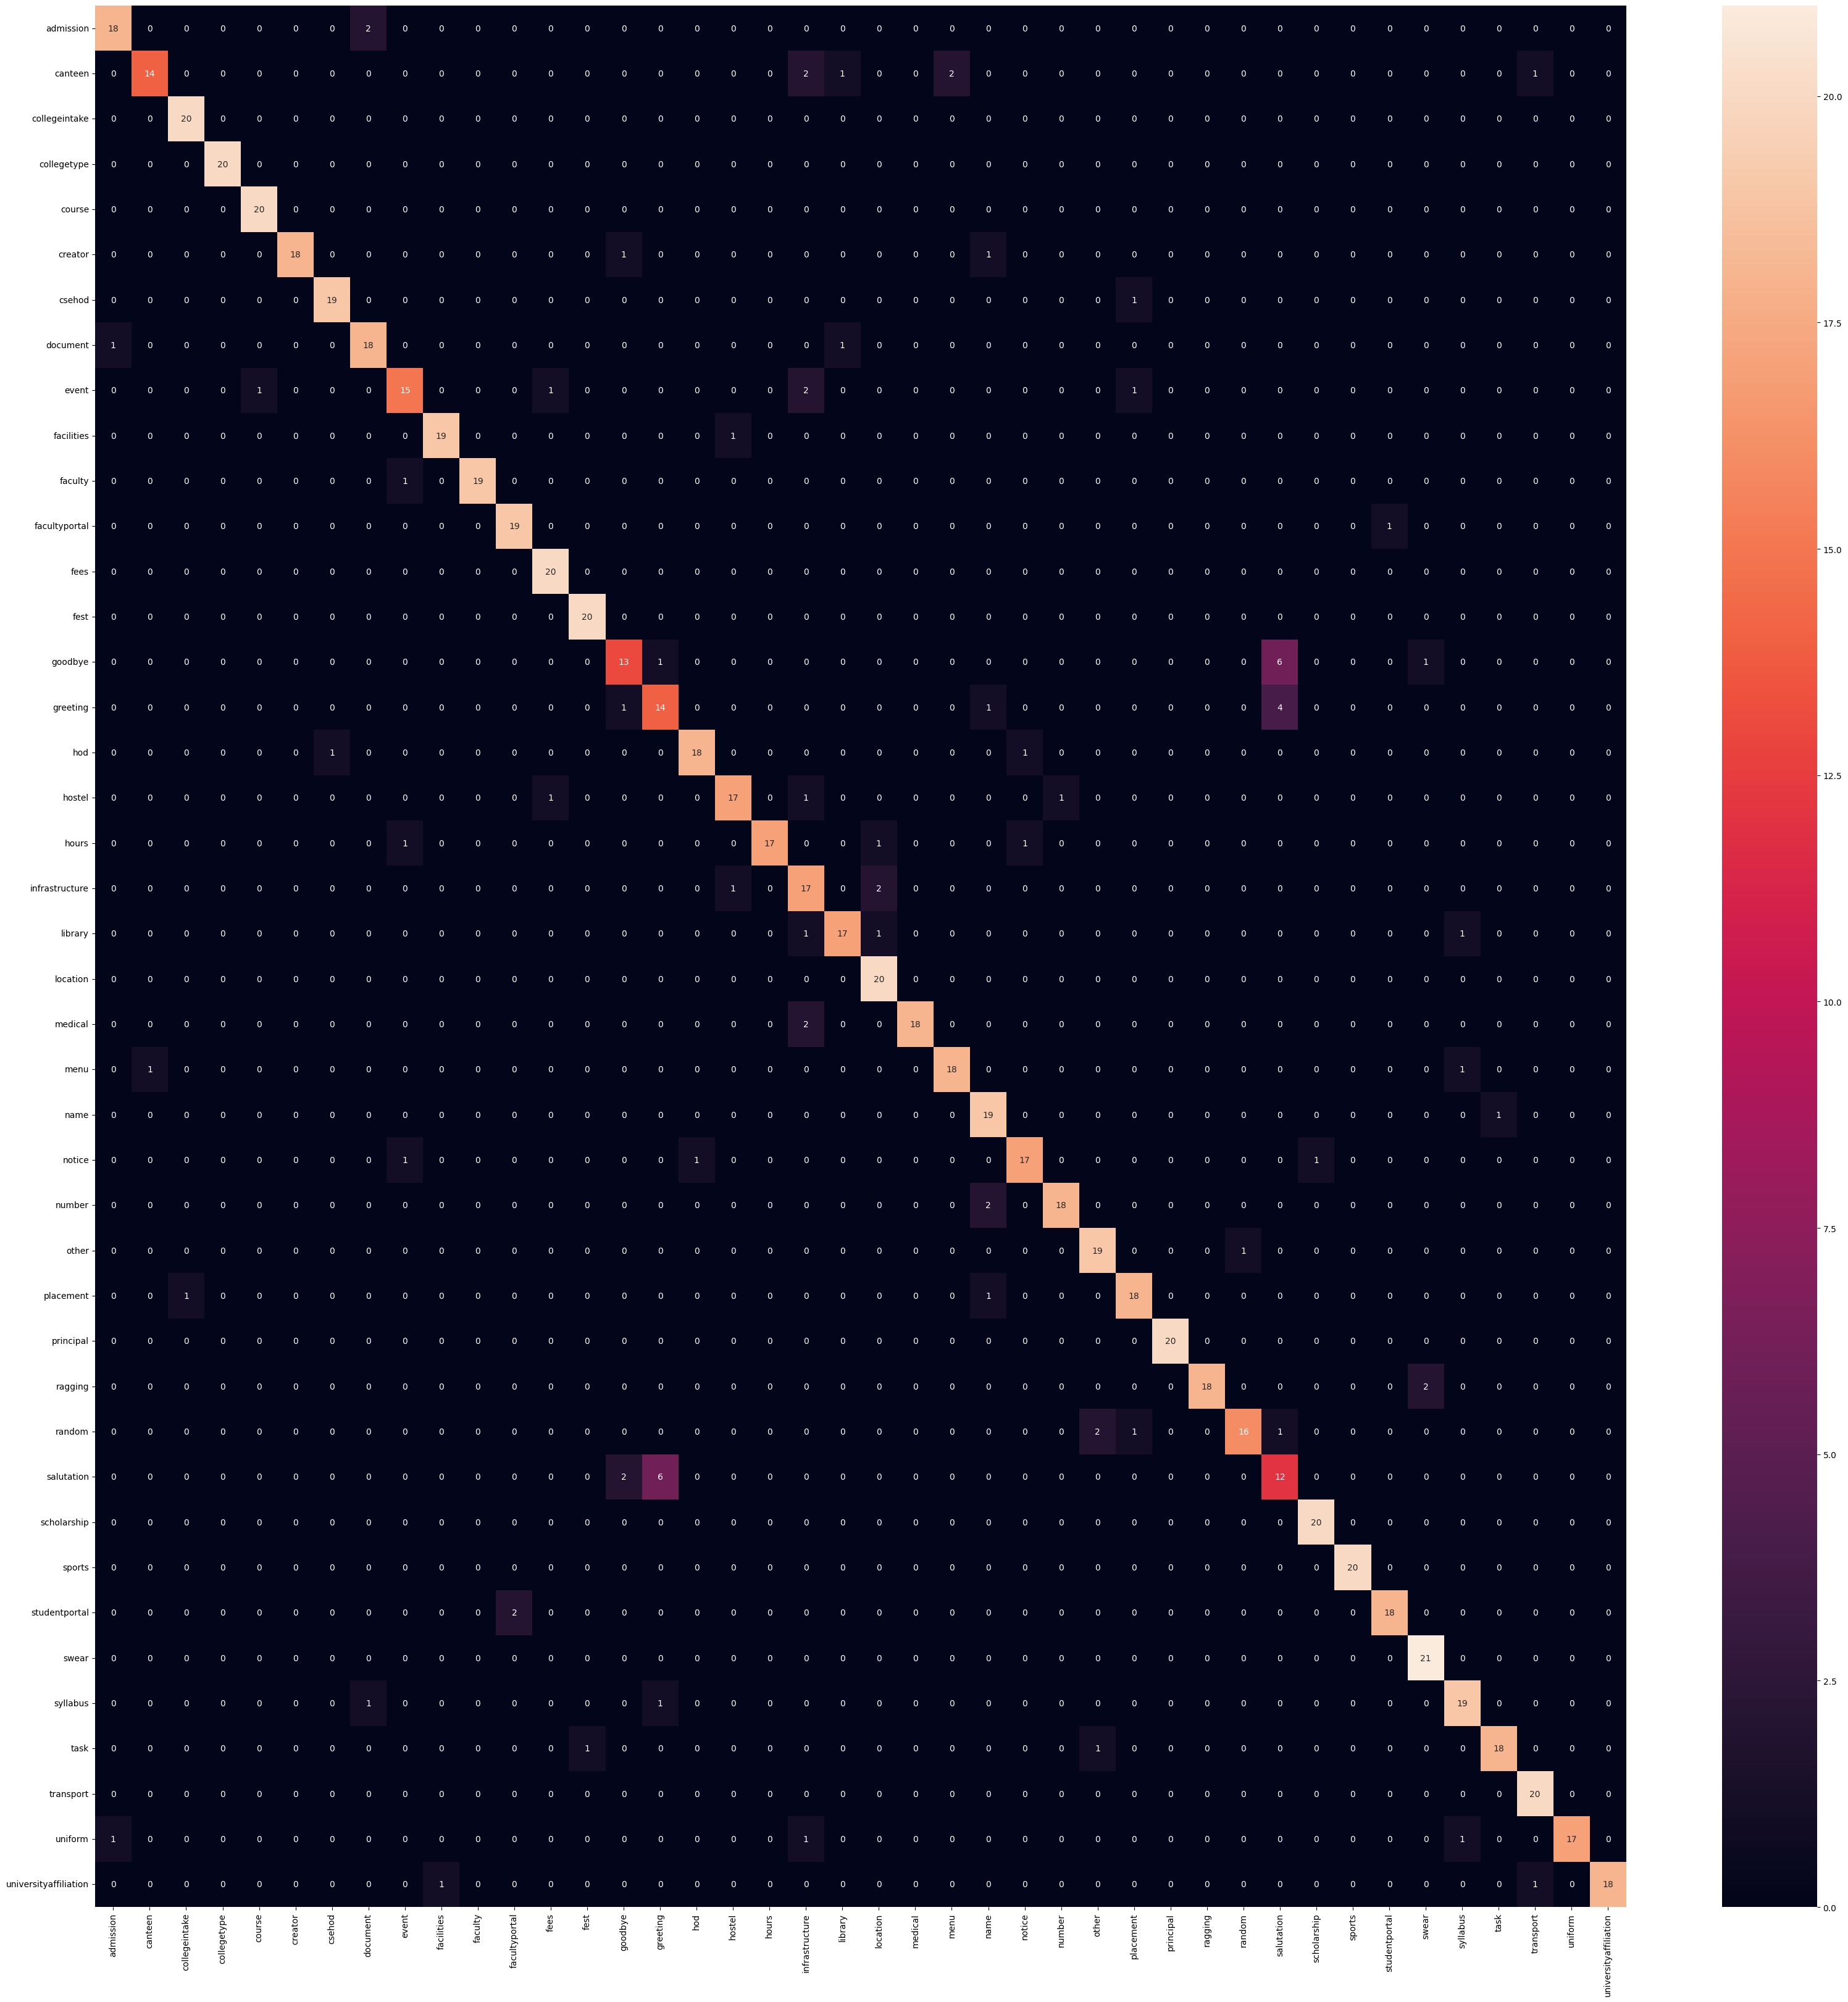

In [82]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/lucy/confusion_matrix_bert.png')

# B. Train DistilBERT

In [84]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, distilbert_model, distilbert_optimizer)

    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 2.235

Training Accuracy: 38.468 %

 Epoch 2 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 1.526

Training Accuracy: 56.496 %

 Epoch 3 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 1.154

Training Accuracy: 66.806 %

 Epoch 4 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.952

Training Accuracy: 71.901 %

 Epoch 5 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.791

Training Accuracy: 76.788 %

 Epoch 6 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.683

Training Accuracy: 80.125 %

 Epoch 7 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.625

Training Accuracy: 81.049 %

 Epoch 8 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 0.583

Training Accuracy: 81.436 %

 Epoch 9 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 

## Analysis of Training

In [85]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

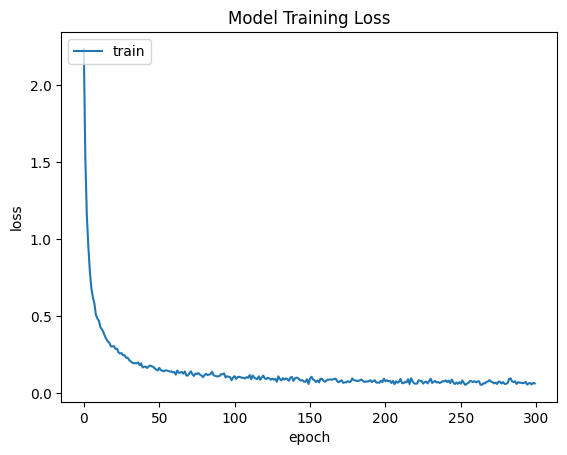

In [86]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/distilbert_model_loss.png")
plt.show()

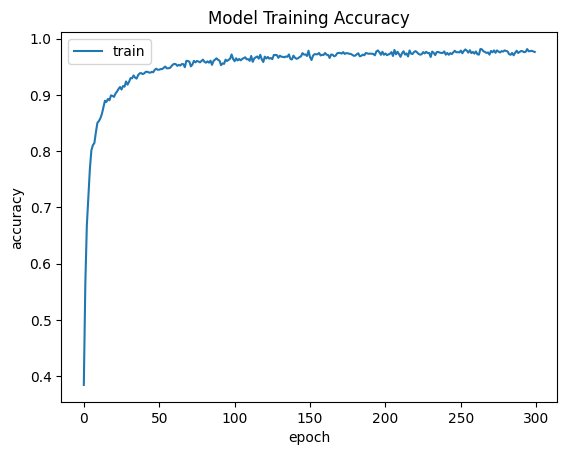

In [87]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/distilbert_model_accuracy.png")
plt.show()

## Saving the Lucy model

In [88]:
model_save_name = "lucy_distilbert.pth"
PATH = F"/content/drive/MyDrive/Colab Notebooks/lucy/{model_save_name}"

In [89]:
torch.save(distilbert_model.state_dict(), PATH)

## Testing the BERT

In [90]:
distilbert_model = lucy_model(device, model="distilbert")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [104]:
distilbert_model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

<All keys matched successfully>

In [105]:
test_y_preds = predict(test_dataloader, distilbert_model)

In [106]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [107]:
classes = le.classes_.tolist()

In [108]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)

In [109]:
test_y_true = le.inverse_transform(test_y_true)

In [110]:
test_y_preds = le.inverse_transform(test_y_preds)

In [111]:
# Classification report
c = classification_report(test_y_true, test_y_preds)
print(c)

                       precision    recall  f1-score   support

            admission       0.95      0.90      0.92        20
              canteen       0.94      0.80      0.86        20
        collegeintake       0.95      0.95      0.95        20
          collegetype       1.00      1.00      1.00        20
               course       0.90      0.95      0.93        20
              creator       0.94      0.80      0.86        20
               csehod       0.95      0.95      0.95        20
             document       0.91      1.00      0.95        20
                event       0.76      0.80      0.78        20
           facilities       0.95      0.90      0.92        20
              faculty       1.00      0.95      0.97        20
        facultyportal       1.00      1.00      1.00        20
                 fees       0.95      1.00      0.98        20
                 fest       1.00      0.90      0.95        20
              goodbye       0.61      0.67      0.64  

89% testing accuracy is pretty good.

In [99]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

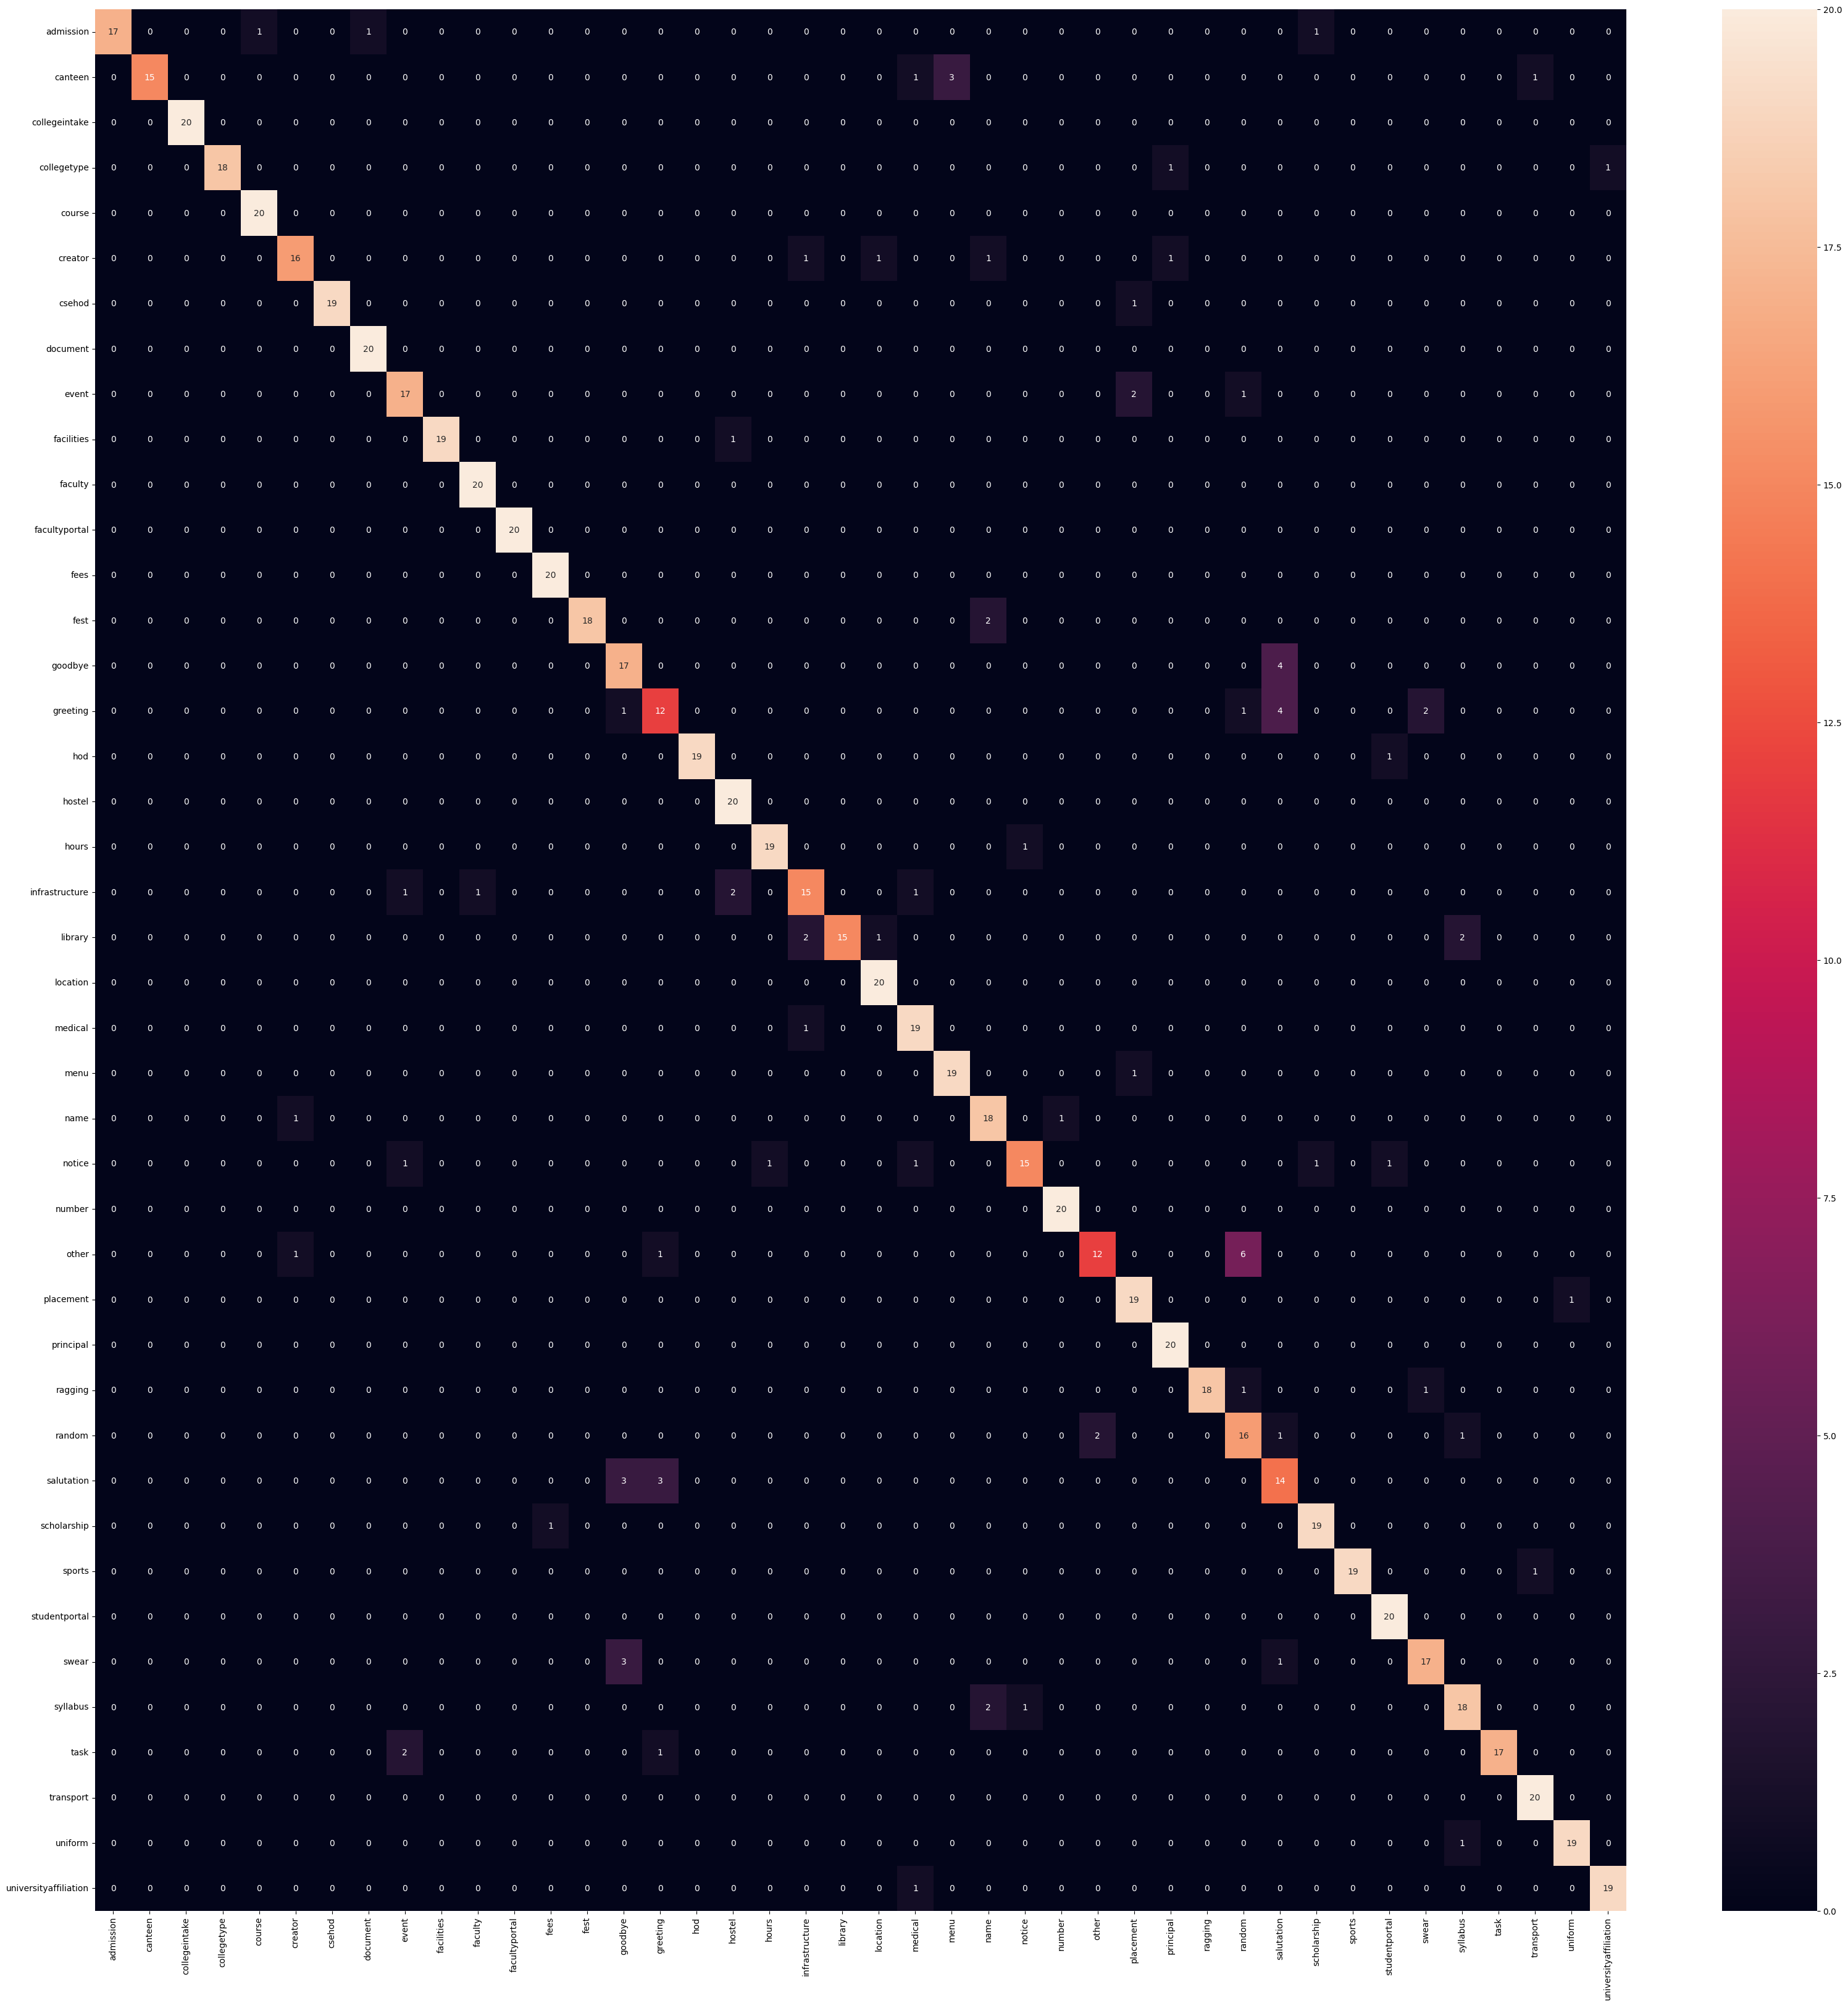

In [100]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/lucy/confusion_matrix_distilbert.png')

# C. Train RoBERTa

In [112]:
# empty lists to store training  loss of each epoch
train_losses=[]

# empty lists to store training  accuracy of each epoch
train_accuracies=[]

for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, train_accuracy ,_ = train(train_dataloader, roberta_model, roberta_optimizer)

    # append training loss
    train_losses.append(train_loss)

    # appedn training accuracy
    train_accuracies.append(train_accuracy)

    # it can make your experiment reproducible, similar to set  random seed to all options where there needs a random seed.    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'\nTraining Accuracy: {train_accuracy * 100:.3f} %')


 Epoch 1 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.739

Training Accuracy: 2.712 %

 Epoch 2 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.639

Training Accuracy: 4.261 %

 Epoch 3 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.562

Training Accuracy: 5.483 %

 Epoch 4 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.481

Training Accuracy: 8.582 %

 Epoch 5 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.355

Training Accuracy: 12.068 %

 Epoch 6 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.239

Training Accuracy: 13.647 %

 Epoch 7 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.105

Training Accuracy: 16.538 %

 Epoch 8 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 3.024

Training Accuracy: 18.743 %

 Epoch 9 / 300
Batch    50  of    105.
Batch   100  of    105.

Training Loss: 2.96

## Analysis of Training

In [113]:
train_losses = np.array(train_losses)
train_accuracies = np.array(train_accuracies)

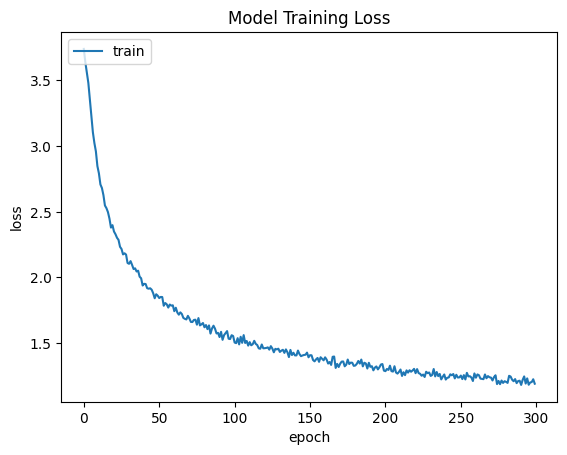

In [114]:
plt.plot(train_losses)
plt.title("Model Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/roberta_model_loss.png")
plt.show()

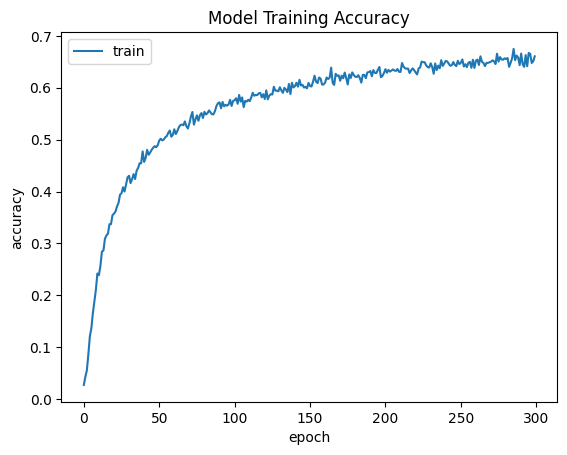

In [115]:
plt.plot(train_accuracies)
plt.title("Model Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(['train'], loc="upper left")
plt.savefig("/content/drive/MyDrive/Colab Notebooks/lucy/roberta_model_accuracy.png")
plt.show()

## Saving the Lucy model

In [116]:
model_save_name = "lucy_roberta.pth"
PATH = F"/content/drive/MyDrive/Colab Notebooks/lucy/{model_save_name}"

In [117]:
torch.save(roberta_model.state_dict(), PATH)

## Testing the BERT

In [118]:
roberta_model = lucy_model(device, model="roberta")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [119]:
roberta_model.load_state_dict(torch.load(PATH, map_location=torch.device(device)))

<All keys matched successfully>

In [120]:
test_y_preds = predict(test_dataloader, roberta_model)

In [121]:
test_y_preds = np.argmax(torch.tensor(test_y_preds), axis=-1)

In [122]:
classes = le.classes_.tolist()

In [123]:
test_y_true = []
for batch in test_dataloader:
   _, _, labels = batch
   a = torch.Tensor.tolist(labels)
   for i in a:
     test_y_true.append(i)

In [124]:
test_y_true = le.inverse_transform(test_y_true)

In [125]:
test_y_preds = le.inverse_transform(test_y_preds)

In [126]:
# Classification report
c = classification_report(test_y_true, test_y_preds)
print(c)

                       precision    recall  f1-score   support

            admission       0.84      0.80      0.82        20
              canteen       0.50      0.60      0.55        20
        collegeintake       0.94      0.75      0.83        20
          collegetype       0.70      0.95      0.81        20
               course       0.75      0.45      0.56        20
              creator       0.79      0.55      0.65        20
               csehod       1.00      0.85      0.92        20
             document       0.72      0.65      0.68        20
                event       0.83      0.50      0.62        20
           facilities       0.90      0.90      0.90        20
              faculty       0.88      0.75      0.81        20
        facultyportal       0.86      0.95      0.90        20
                 fees       0.68      0.65      0.67        20
                 fest       0.89      0.80      0.84        20
              goodbye       0.45      0.48      0.47  

In [127]:
# Build confusion matrix
cf_matrix = confusion_matrix(test_y_true, test_y_preds)

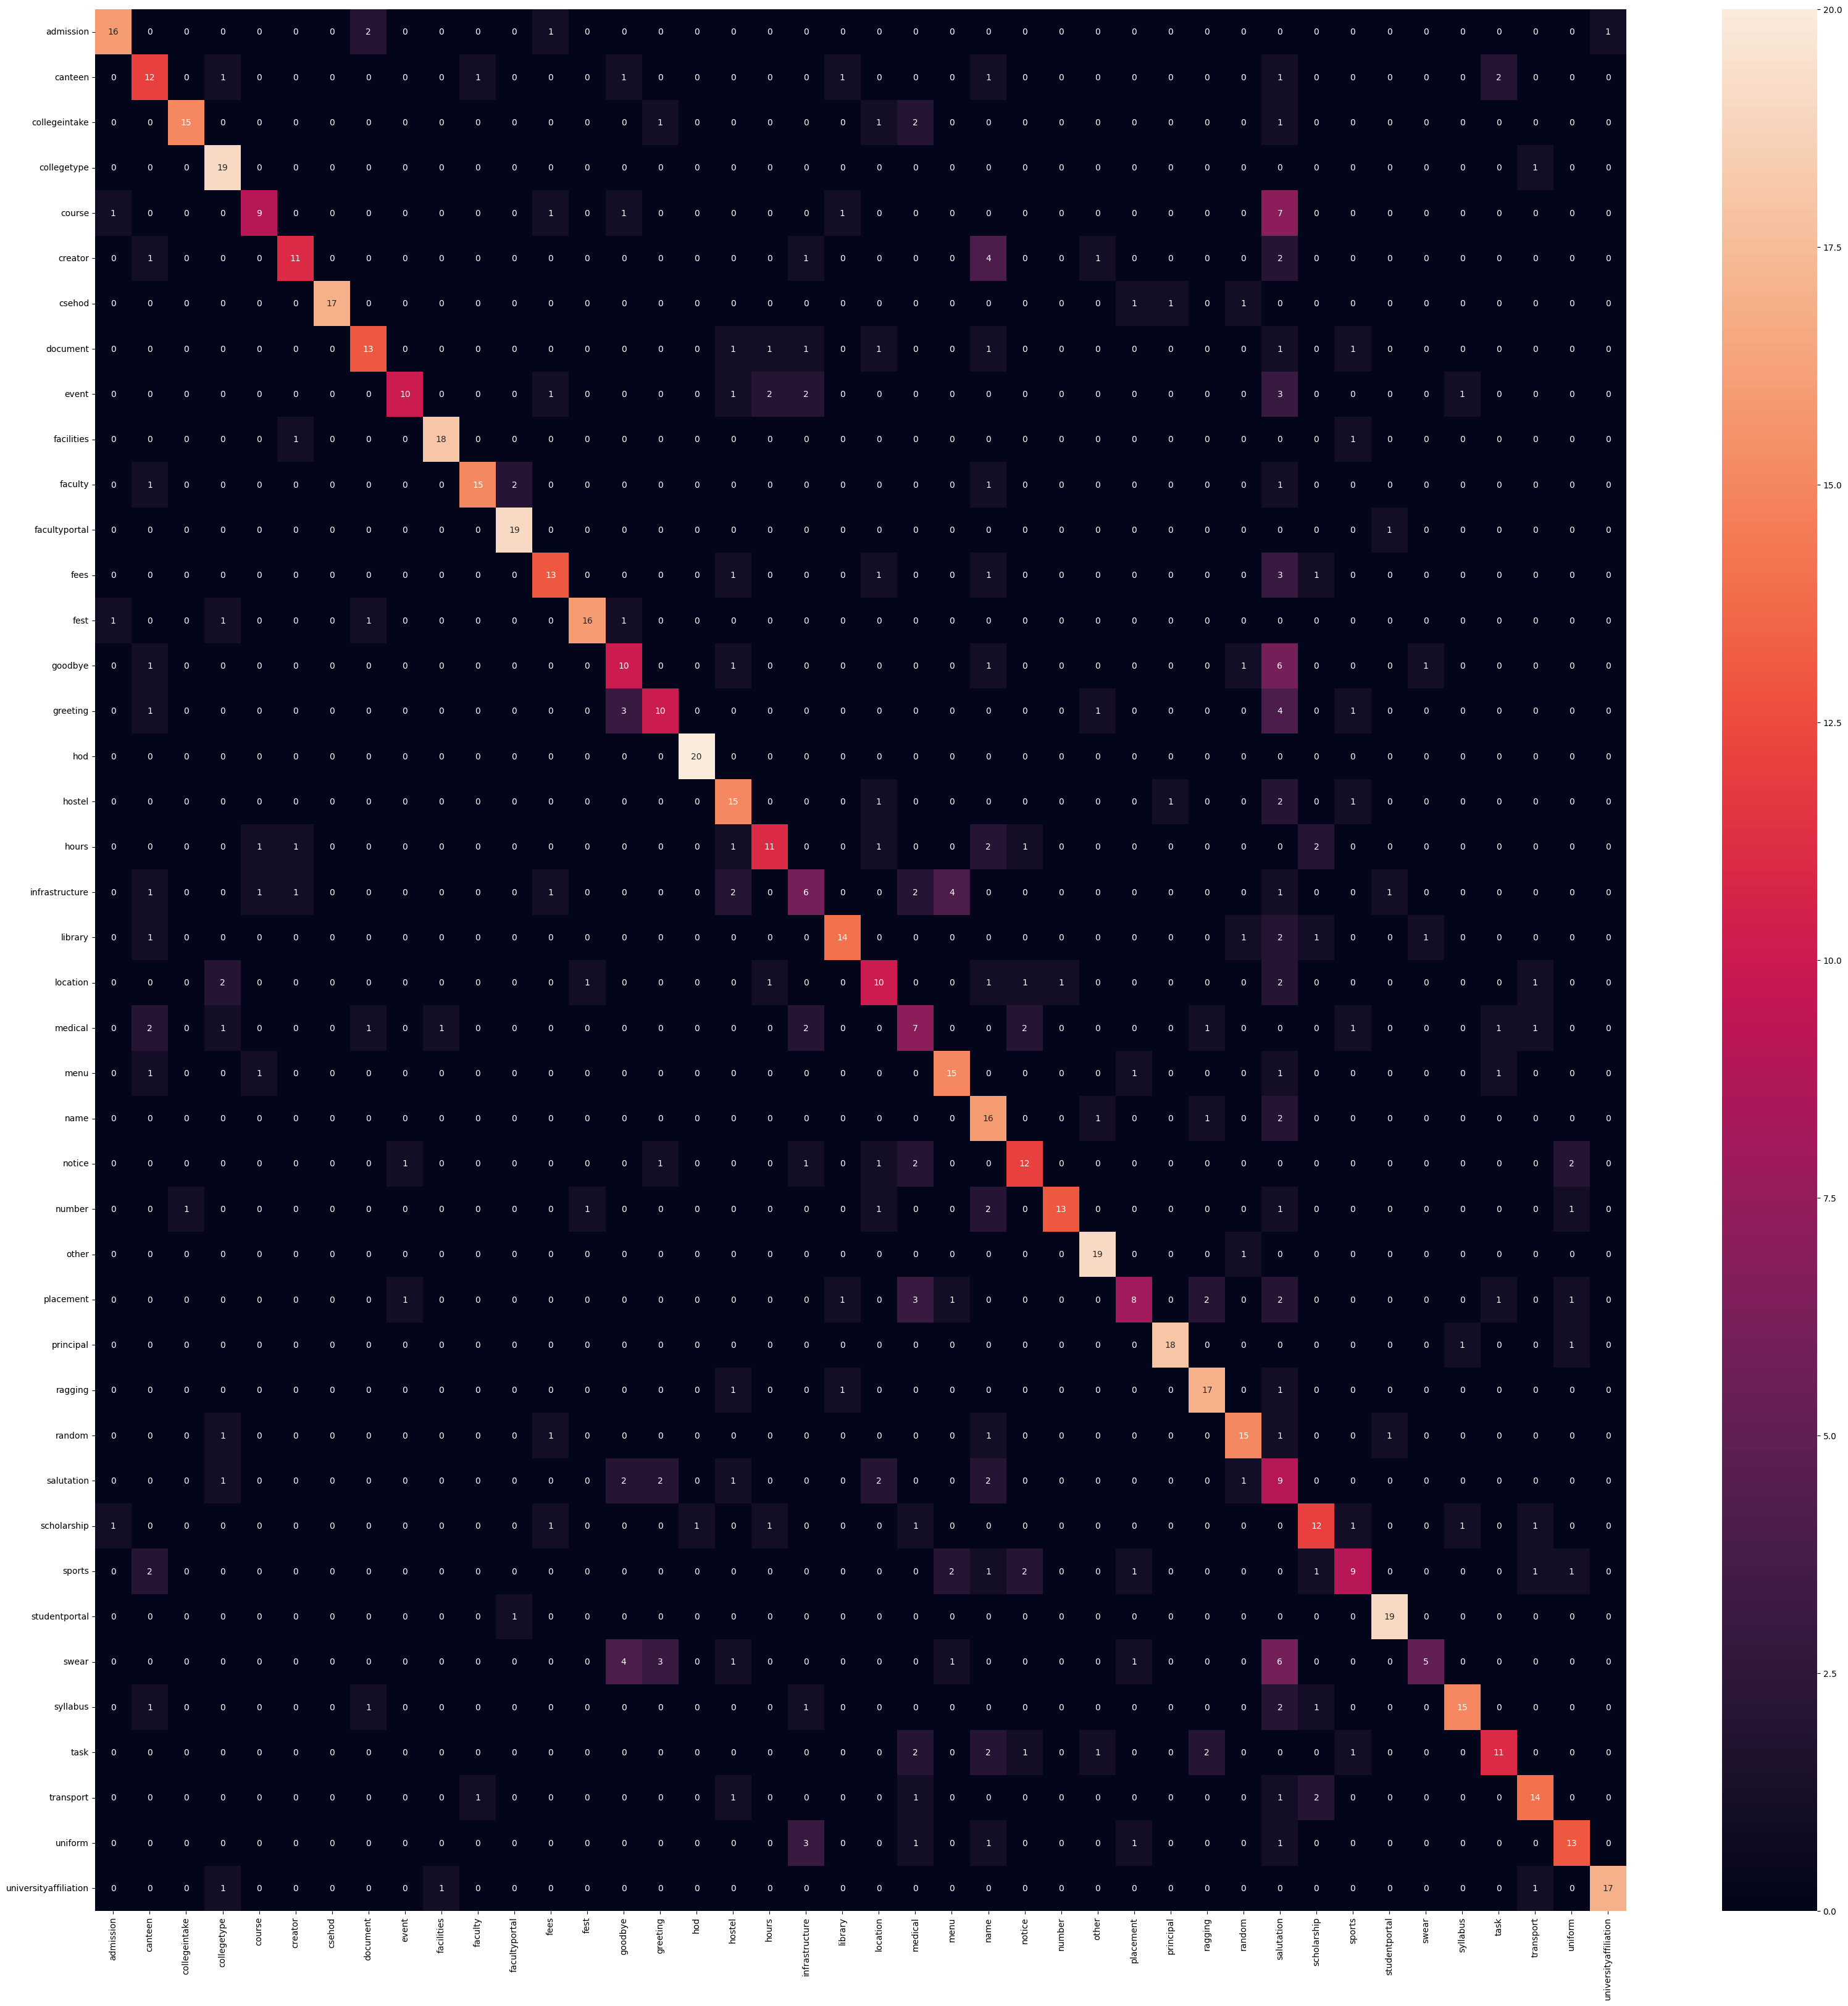

In [128]:
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes], columns = [i for i in classes])
plt.figure(figsize = (40,40))
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
sn.heatmap(df_cm, annot=True)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/lucy/confusion_matrix_roberta.png')